## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
    
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2021-09-17 12:29:54.156460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-17 12:29:54.156488: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Controllable hyperparameters

In [2]:
# We can use these to slice a pandas datetime index
warmup_start = '20210601'
warmup_end = '20210630'
train_start = '20210701'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

# How long can a person take to progress?
transition_window = 30

# CovidEstim Hyper param
T_serial = 5.8

# Vaccines are 90% effective at preventing infection
# according to a study of 4000 healthcare workers in early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7013e3.htm
vax_asymp_risk = 0.90
# Vaccines are 94% effective at preventing symptomatic
# according to a study of healthcare workers in early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7020e2.htm
vax_mild_risk = 0.94
vax_extreme_risk = 0.94
# Vaccines are 94% effective at preventing hospitalization
# according to a study of adults over 65 early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7018e1.htm?s_cid=mm7018e1_w
vax_general_ward_risk = 0.94

# Parameters for the Beta distribution prior over rho, the probablility that
# someone progresses to the next state. Here we use a uniform distribution
# for all compartments, but we could specify a different prior for each M, X, G
alpha_bar = 1
beta_bar = 1

# Parameters for the positive truncated Normal distribution prior over lambda, the rate
# parameter of the Poisson distribution controlling pi,
# which determines how quickly someone who progresses does so
# Here we use a diffuse normal distribution with a mean at 10 days for all compartments
# but we could specify a different prior for each M, X, G
lambda_bar = 10
sigma_bar = 5

# Parameters for the positive truncated Normal distribution prior over nu, the parameter used
# to scale the poisson distribution governed by pi, allowing for a more expressive
# range of possible transition days
# Here we use a diffuse normal distribution with a mean at 10 for all compartments
# but we could specify a different prior for each M, X, G
nu_bar = 10
tau_bar = 5

# Learning rate
learning_rate = 1e-1


## Model size globals


In [3]:
# Globals are ugly
# could create an enum or make them properties of a model class or something
COMPARTMENTS = 4
ASYMP = 0
MILD = 1
EXTREME = 2
GENERAL_WARD = 3

## Create Warmup Data

In [4]:
# Local data folder containing downloads from OWID, HHS, and CovidEstim
# Filenames are the date the data was accessed
data_dir = './data'

covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

covid_estim_path = os.path.join(data_dir,'covidestim', covid_estim_date+'.csv')
hhs_path = os.path.join(data_dir,'hhs', hhs_date+'.csv')
owid_path = os.path.join(data_dir,'owid', owid_date+'_vaccinations.csv')




### Read CovidEstim


In [5]:
# Read covid estim
covid_estim = pd.read_csv(covid_estim_path)
# filter to state
covid_estim = covid_estim[covid_estim['state']==state]
# Make sure date is unique
assert len(covid_estim)==len(covid_estim.date.unique())

# create datetime index
covid_estim.loc[:, 'date'] = pd.to_datetime(covid_estim['date'])
covid_estim = covid_estim.set_index('date').sort_index()
# Rename to match our compartments
covid_estim = covid_estim.rename(columns={'infections':'asymp',
                                          'severe':'extreme',
                                          'symptomatic':'mild'
                                          })


### Read HHS for outcome variable

In [6]:
hhs = pd.read_csv(hhs_path)
hhs = hhs[hhs['state']==state_abbrev]
assert len(hhs) == len(hhs.date.unique())

# we have previous day admissions, so add 1 to date
hhs.loc[:, 'date'] = pd.to_datetime(hhs['date']) + pd.DateOffset(days=1)
hhs = hhs.set_index('date').sort_index()
hhs = hhs.rename(columns={'previous_day_admission_adult_covid_confirmed':'general_ward'})


### Read Our World In Data for a clean CDC state-level vaccine timeseries

In [7]:
owid = pd.read_csv(owid_path)
owid = owid[owid['location']==state]
owid.loc[:, 'date'] = pd.to_datetime(owid['date'])
owid = owid.set_index('date').sort_index()
# There are NaN's in the vaccine timeseries, so linearly interpolate
owid.loc[:, 'people_fully_vaccinated_per_hundred'] = owid[['people_fully_vaccinated_per_hundred']].interpolate(method='linear')
owid['vax_pct'] = owid[['people_fully_vaccinated_per_hundred']]*0.01

### Merge all warmup data together on the common date index

In [8]:
df = pd.merge(hhs[['general_ward']],
              covid_estim[['asymp','extreme','mild', 'Rt']],
              how='outer',
              left_index=True, right_index=True).merge(owid[['vax_pct']], how='outer', left_index=True, right_index=True)


### Create arrays of warmup data

In [9]:
warmup_infected = {}
warmup_asymp = {}
warmup_mild = {}
warmup_extreme = {}

not_vaxxed=0
vaxxed=1

# vaccines protect from infection/asymp/mild/extreme/general
# multiply population vaccinated by (1-protection %) to get vaccinated
warmup_asymp[vaxxed] = (df.loc[warmup_start:warmup_end, 'vax_pct'] * (1-vax_asymp_risk) * \
                           df.loc[warmup_start:warmup_end, 'asymp']).values
warmup_asymp[not_vaxxed] = df.loc[warmup_start:warmup_end, 'asymp'].values - warmup_asymp[vaxxed]

warmup_mild[vaxxed] = (df.loc[warmup_start:warmup_end, 'vax_pct'] * (1-vax_mild_risk) * \
                           df.loc[warmup_start:warmup_end, 'mild']).values
warmup_mild[not_vaxxed] = df.loc[warmup_start:warmup_end, 'mild'].values - warmup_mild[vaxxed]

warmup_extreme[vaxxed] = (df.loc[warmup_start:warmup_end, 'vax_pct'] * (1-vax_extreme_risk) * \
                           df.loc[warmup_start:warmup_end, 'extreme']).values
warmup_extreme[not_vaxxed] = df.loc[warmup_start:warmup_end, 'extreme'].values - warmup_extreme[vaxxed]

warmup_infected[vaxxed] = warmup_asymp[vaxxed] + warmup_mild[vaxxed] + warmup_extreme[vaxxed]
warmup_infected[not_vaxxed] = warmup_asymp[not_vaxxed] + warmup_mild[not_vaxxed] + warmup_extreme[not_vaxxed]

training_rt = df.loc[train_start:train_end,'Rt'].values
training_general_ward = df.loc[train_start:train_end,'general_ward'].values

# Start the model from the training period so we are continuous
testing_rt = df.loc[train_start:test_end,'Rt'].values
testing_general_ward = df.loc[train_start:test_end,'general_ward'].values


## Define The Model

In [10]:
class CovidModel(tf.keras.Model):
    
    def __init__(self, transition_window, T_serial,
                 alpha_bar_M, beta_bar_M, alpha_bar_X, beta_bar_X, alpha_bar_G, beta_bar_G,
                 lambda_bar_M, sigma_bar_M, lambda_bar_X, sigma_bar_X, lambda_bar_G, sigma_bar_G,
                 nu_bar_M, tau_bar_M, nu_bar_X, tau_bar_X, nu_bar_G, tau_bar_G,
                 compartments=COMPARTMENTS):
        """Covid Model 1.5
        
        Args:
            transition_window (int): J in our notation, the number of days to consider a 
                possible transition to a more severe state
            T_serial (float): CovidEstim infection hyperparameter
            alpha_bar_M (float): A positive shape hyperparameter controlling the Beta distribution prior on rho_M,
                the likelihood that an Asymptomatic individual progresses to the Mild state
            beta_bar_M (float): The second positive shape hyperparameter controlling the Beta distribution prior on rho_M,
                the likelihood that an Asymptomatic individual progresses to the Mild state
            alpha_bar_X (float): A positive shape hyperparameter controlling the Beta distribution prior on rho_X,
                the likelihood that an individual with Mild symptoms progresses to the eXtreme state
            beta_bar_X (float): The second positive shape hyperparameter controlling the Beta distribution prior on rho_X,
                the likelihood that an individual with Mild symptoms progresses to the eXtreme state
            alpha_bar_G (float): A positive shape hyperparameter controlling the Beta distribution prior on rho_G,
                the likelihood that an individual with eXtreme symptoms progresses to the hospital
            beta_bar_G (float): The second positive shape hyperparameter controlling the Beta distribution prior on rho_G,
                the likelihood that an Asymptomatic individual progresses to the Mild state
            lambda_bar_M (float): The mean of a strictly-positive Normal distribution prior over lambda_M, the rate
                of the Poisson distribution that governs how quickly individuals transition from Asymptomatic to Mild
            sigma_bar_M (float): The standard deviation of a strictly-positive Normal distribution prior over lambda_M,
                the rate of the Poisson distribution that governs how quickly individuals transition from Asymptomatic to Mild
            lambda_bar_X (float): The mean of a strictly-positive Normal distribution prior over lambda_X, the rate
                of the Poisson distribution that governs how quickly individuals transition from Mild to eXtreme
            sigma_bar_X (float): The standard deviation of a strictly-positive Normal distribution prior over lambda_X,
                the rate of the Poisson distribution that governs how quickly individuals transition from Mild to eXtreme
            lambda_bar_G (float): The mean of a strictly-positive Normal distribution prior over lambda_G, the rate
                of the Poisson distribution that governs how quickly individuals transition from eXtreme to the General ward
            sigma_bar_G (float): The standard deviation of a strictly-positive Normal distribution prior over lambda_G,
                the rate of the Poisson distribution that governs how quickly individuals transition from eXtreme to the General Ward
            nu_bar_M (float): The mean of a strictly-positive Normal distribution prior over nu_M, 
                which scales the poisson PMF used to determine progression to the next state
            tau_bar_M (float): The standard deviation of a strictly-positive Normal distribution prior over nu_M, 
                which scales the poisson PMF used to determine progression to the next state
            nu_bar_X (float): The mean of a strictly-positive Normal distribution prior over nu_X, 
                which scales the poisson PMF used to determine progression to the next state
            tau_bar_X (float): The standard deviation of a strictly-positive Normal distribution prior over nu_X, 
                which scales the poisson PMF used to determine progression to the next state
            nu_bar_G (float): The mean of a strictly-positive Normal distribution prior over nu_G, 
                which scales the poisson PMF used to determine progression to the next state
            tau_bar_G (float): The standard deviation of a strictly-positive Normal distribution prior over nu_G, 
                which scales the poisson PMF used to determine progression to the next state
        """
        super(CovidModel, self).__init__()
        
        self.transition_window = transition_window
        self.T_serial = T_serial
        self.compartments = compartments
        
        # create dictionaries to store model parameters / prior distributions
        self._initialize_parameters(lambda_bar_M, lambda_bar_X, lambda_bar_G,
                                    nu_bar_M, nu_bar_X, nu_bar_G)
        self._initialize_priors(alpha_bar_M, beta_bar_M, alpha_bar_X, beta_bar_X, alpha_bar_G, beta_bar_G,
                                lambda_bar_M, sigma_bar_M, lambda_bar_X, sigma_bar_X, lambda_bar_G, sigma_bar_G,
                                nu_bar_M, tau_bar_M, nu_bar_X, tau_bar_X, nu_bar_G, tau_bar_G)
        
    
    def call(self, inputs, debug_disable_prior=False, return_all=False):
        """Run covid model 1.5
        
        Args:
            inputs (tuple(tf.Tensor)): A tuple of all input tensors we need. It should be, in order:
                (rt,
                 warmup_asymp_not_vaxxed, warmup_asymp_vaxxed,
                 warmup_mild_not_vaxxed, warmup_mild_vaxxed,
                 warmup_extreme_not_vaxxed, warmup_extreme_vaxxed)
                rt should be size (1, days_to_forecast), while
                warmup data should be size (1, days_of_warmup)
            debug_disable_prior (bool): If True, will disable adding the prior to the loss. Used to debug gradients
        Returns:
            tf.Tensor: A tensor size (1, days_to_forecast) of incident hospital admissions
        """
        
        # Tensorflow models are typically a single tensor or a tuple of multiple tensors
        # This function accepts all the input tensors we need (r_t, warmup for AMX, both vaxxed and non-vaxxed)
        # and returns r_t, along with dictionaries keyed on vaccination status for easier use.
        r_t, warmup_asymp, warmup_mild, warmup_extreme = self._parse_inputs(inputs)
        
        # We need to know how long the warmup data is and how long to forecast for
        # Take the last dimension one of the warmup data tensors
        # Any will do, so we arbitrariliy pick the vax_status=0 asymptomatic
        warmup_days_val = warmup_asymp[0].shape[-1]
        # take the last dimension of r_t
        forecast_days_val = r_t.shape[-1]
        
        # It's a little weird to iteratively write to tensors one day at a time
        # To do this, we'll use TensorArray's, arrays of tensors where each element is a tensor representing
        # one compartment/vaccine status/ day
        # This helper function creates a nested dictionary keyed on:
        #  compartment-> 
        #      vaccinestatus->
        #           TensorArray with one tensor per day from:
        #               warmup_start to forecast_end for any quantities with warmup data
        #               forecast_start to forecast_end for the outcome, which does not have warmup data
        forecasted_fluxes = self._initialize_flux_arrays(warmup_asymp, warmup_mild, warmup_extreme,
                                                         warmup_days_val, forecast_days_val)
        
        # Our model parameters have several constraints (being between 0-1, being positive)
        # So we need to transform them from the unconstrained space they are modeled in
        # This call transforms them and saves them properties of this model object (self):
        #     epsilon, a scalar with value between 0-1
        #     delta, a dictionary of scalars keyed on vaccination status with values between 0-1
        #     rho_M, rho_X, rho_G: dictionaries of tensors keyed on vaccination status with values between 0-1
        #     lambda_M,  lambda_X, lambda_G: dictionaries of positive-valued tensors keyed on vaccination status
        #     nu_M, nu_X, nu_G: dictionaries of positive-valued tensors keyed on vaccination status
        #     poisson_M, poisson_X, poisson_G: dictionaries of probability distribution objects keyed on vaccine status
        #     pi_M, pi_X, pi_G: dictionaries of tensor arrays with 1 element for each of the past J days
        #     previously_asymptomatic, previously_mild, previously_extreme: dictionaries of tensor arrays with 1 element for each of the past J days
        
        self._constrain_parameters()
        
        if not debug_disable_prior:
            self._add_prior_loss()

        # forecast from the end of warmup to the end of forecasting
        for day in range(warmup_days_val, forecast_days_val+warmup_days_val):
            
            # Start with asymptomatic
            asymp_t_1_no_vax = forecasted_fluxes[ASYMP][0].read(day-1)
            asymp_t_1_vax = forecasted_fluxes[ASYMP][1].read(day-1)
            combined_asymp_covariate = asymp_t_1_no_vax + self.epsilon * asymp_t_1_vax
            
            

            for vax_status in range(2):
                
                forecasted_fluxes[ASYMP][vax_status]  = forecasted_fluxes[ASYMP][vax_status].write(day,
                    tf.squeeze(combined_asymp_covariate * self.delta[vax_status] * r_t[day-warmup_days_val]* (1/self.T_serial))
                )

                # get last J days of AMX
                for j in range(self.transition_window):
                    self.previously_asymptomatic[vax_status] = self.previously_asymptomatic[vax_status].write(j,
                        forecasted_fluxes[ASYMP][vax_status].read(day-(j+1)))

                    self.previously_mild[vax_status] = self.previously_mild[vax_status].write(j,
                        forecasted_fluxes[MILD][vax_status].read(day-(j+1)))
                    self.previously_extreme[vax_status] = self.previously_extreme[vax_status].write(j,
                        forecasted_fluxes[EXTREME][vax_status].read(day-(j+1)))                    
                
                previously_asymptomatic_tensor = self.previously_asymptomatic[vax_status].stack()
                previously_mild_tensor = self.previously_mild[vax_status].stack()
                previously_extreme_tensor = self.previously_extreme[vax_status].stack()
               
                forecasted_fluxes[MILD][vax_status]  = forecasted_fluxes[MILD][vax_status].write(day,
                    tf.reduce_sum(previously_asymptomatic_tensor * self.rho_M[vax_status] * self.pi_M[vax_status], axis=0)
                )
                     
                forecasted_fluxes[EXTREME][vax_status]  = forecasted_fluxes[EXTREME][vax_status].write(day,
                    tf.reduce_sum(previously_mild_tensor * self.rho_X[vax_status] * self.pi_X[vax_status], axis=0)
                )
                    
                forecasted_fluxes[GENERAL_WARD][vax_status]  = forecasted_fluxes[GENERAL_WARD][vax_status].write(day-warmup_days_val,
                    tf.reduce_sum(previously_extreme_tensor * self.rho_G[vax_status] * self.pi_G[vax_status], axis=0)
                )

                
        # Re-combine vaccinated and unvaxxed for our output
        if return_all:
            result = forecasted_fluxes
        else:
            result = forecasted_fluxes[GENERAL_WARD][0].stack()+ forecasted_fluxes[GENERAL_WARD][1].stack()
        
        # Tensorflow thinks we didn't use every array, so we gotta mark them as used
        # TODO: did i screw up?
        self._mark_arrays_used(forecasted_fluxes)
            
        return result
    
    def _initialize_parameters(self, lambda_bar_M, lambda_bar_X, lambda_bar_G,
                               nu_bar_M, nu_bar_X, nu_bar_G):
        """Helper function to hide the book-keeping behind initializing model parameters
        
        TODO: Replace with better initializations
        """
        
        self.model_params = {}
        
        for compartment in range(self.compartments):
            self.model_params[compartment] = {}
            for vax_status in [0, 1]:
                self.model_params[compartment][vax_status] = {}
        
        self.unconstrained_eps = self.add_weight(shape=tf.TensorShape(1), initializer="random_normal",
                                                 trainable=True, name=f'eps')
        self.unconstrained_delta = {}
        
        # Fix delta = 1 for non-vax 
        self.unconstrained_delta[0] = tf.Variable([1e8], name='A_delta_0', trainable=False)
        # TODO: debug
        # if this isn't add weight the gradient doesn't get tracked for some reason
        self.unconstrained_delta[1] = self.add_weight(shape=tf.TensorShape(1), initializer="random_normal",
                                                      trainable=True, name=f'A_delta_1')
        
        # initialize model parameters
        for vax_status in [0, 1]:
            
            self.model_params[MILD][vax_status]['unconstrained_rho'] = tf.Variable([0], name=f'M_rho_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[MILD][vax_status]['unconstrained_lambda'] = tf.Variable([lambda_bar_M], name=f'M_lambda_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[MILD][vax_status]['unconstrained_nu'] = tf.Variable([nu_bar_M], name=f'M_nu_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[EXTREME][vax_status]['unconstrained_rho'] = tf.Variable([0], name=f'X_rho_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[EXTREME][vax_status]['unconstrained_lambda'] = tf.Variable([lambda_bar_X], name=f'X_lambda_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[EXTREME][vax_status]['unconstrained_nu'] = tf.Variable([nu_bar_X], name=f'X_nu_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[GENERAL_WARD][vax_status]['unconstrained_rho'] = tf.Variable([0], name=f'G_rho_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[GENERAL_WARD][vax_status]['unconstrained_lambda'] = tf.Variable([lambda_bar_G], name=f'G_lambda_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))
            self.model_params[GENERAL_WARD][vax_status]['unconstrained_nu'] = tf.Variable([nu_bar_G], name=f'G_nu_{vax_status}', trainable=True, dtype=tf.float32, shape=tf.TensorShape(1))


        return
    
    def _initialize_priors(self, alpha_bar_M, beta_bar_M, alpha_bar_X, beta_bar_X, alpha_bar_G, beta_bar_G,
                           lambda_bar_M, sigma_bar_M, lambda_bar_X, sigma_bar_X, lambda_bar_G, sigma_bar_G,
                           nu_bar_M, tau_bar_M, nu_bar_X, tau_bar_X, nu_bar_G, tau_bar_G):
        """Helper function to hide the book-keeping behind initializing model priors"""
        
        self.prior_distros = {}
        for compartment in range(self.compartments):
            self.prior_distros[compartment] = {}
            for vax_status in [0, 1]:
                self.prior_distros[compartment][vax_status] = {}
                
        # create prior distributions
        for vax_status in [0,1]:
            self.prior_distros[MILD][vax_status]['rho'] = tfp.distributions.Beta(alpha_bar_M, beta_bar_M)
            self.prior_distros[EXTREME][vax_status]['rho'] = tfp.distributions.Beta(alpha_bar_X, beta_bar_X)
            self.prior_distros[GENERAL_WARD][vax_status]['rho'] = tfp.distributions.Beta(alpha_bar_G, beta_bar_G)
            
            # We want these to be positive so we use a truncated normal with range 0-100
            self.prior_distros[MILD][vax_status]['lambda'] = tfp.distributions.TruncatedNormal(lambda_bar_M, sigma_bar_M, 0, 100)
            self.prior_distros[EXTREME][vax_status]['lambda'] = tfp.distributions.TruncatedNormal(lambda_bar_X, sigma_bar_X, 0, 100)
            self.prior_distros[GENERAL_WARD][vax_status]['lambda'] = tfp.distributions.TruncatedNormal(lambda_bar_G, sigma_bar_G, 0, 100)
            
            self.prior_distros[MILD][vax_status]['nu'] = tfp.distributions.TruncatedNormal(nu_bar_M, tau_bar_M, 0, 100)
            self.prior_distros[EXTREME][vax_status]['nu'] = tfp.distributions.TruncatedNormal(nu_bar_X, tau_bar_X, 0, 100)
            self.prior_distros[GENERAL_WARD][vax_status]['nu'] = tfp.distributions.Normal(nu_bar_G, tau_bar_G, 0, 100)
        
        return
    
    def _parse_inputs(self, inputs):
        """Helper function to hide the logic in parsing the big mess of input tensors we get"""
        (r_t,
         warmup_asymp_not_vaxxed, warmup_asymp_vaxxed,
         warmup_mild_not_vaxxed, warmup_mild_vaxxed,
         warmup_extreme_not_vaxxed, warmup_extreme_vaxxed) = inputs
        
        r_t = tf.squeeze(r_t)
        
        warmup_asymp = {}
        warmup_asymp[0] = tf.squeeze(warmup_asymp_not_vaxxed)
        warmup_asymp[1] = tf.squeeze(warmup_asymp_vaxxed)
        
        warmup_mild = {}
        warmup_mild[0] = tf.squeeze(warmup_mild_not_vaxxed)
        warmup_mild[1] = tf.squeeze(warmup_mild_vaxxed)
        
        warmup_extreme = {}
        warmup_extreme[0] = tf.squeeze(warmup_extreme_not_vaxxed)
        warmup_extreme[1] = tf.squeeze(warmup_extreme_vaxxed)
        
        return r_t, warmup_asymp, warmup_mild, warmup_extreme
        
    def _initialize_flux_arrays(self, warmup_asymp, warmup_mild, warmup_extreme,
                                warmup_days, forecast_days):
        """Helper function to hide the plumbing in creating TensorArrays for every output
        
        Args:
            warmup_days (int): Number of days of warmup data
            forecast_days (int): Number of days to forecast
        Returns
            dict{int:dict{int:TensorArray}}: Nested dictionary keyed on compartment->vaccine status,
                containing a TensorArray for every quantity
        """
        
        forecasted_fluxes = {}
        
        for compartment in range(self.compartments):
            forecasted_fluxes[compartment] = {}
            
            # No need to store warmup data for the outcome
            if compartment == GENERAL_WARD:
                array_size = forecast_days
            else:
                array_size = warmup_days + forecast_days
            
            for vax_status in range(2):
                forecasted_fluxes[compartment][vax_status] = tf.TensorArray(tf.float32, size=array_size,
                                                                            clear_after_read=False,
                                                                            name=f'{compartment}_{vax_status}')
                
        # Write the warmup data to the array so we don't have to look in two places:
        for day in range(warmup_days):
            for vax_status in range(2):
                forecasted_fluxes[ASYMP][vax_status] = \
                    forecasted_fluxes[ASYMP][vax_status].write(day,
                                                                  warmup_asymp[vax_status][day])
                forecasted_fluxes[MILD][vax_status] = \
                    forecasted_fluxes[MILD][vax_status].write(day,
                                                                  warmup_mild[vax_status][day])
                forecasted_fluxes[EXTREME][vax_status] = \
                    forecasted_fluxes[EXTREME][vax_status].write(day,
                                                                  warmup_extreme[vax_status][day])

        return forecasted_fluxes
    
    def _constrain_parameters(self):
        """Helper function to hide the plumbing of creating the constrained parameters and other model TensorArrays"""
        
        # Must be 0-1
        self.epsilon = tf.math.sigmoid(self.unconstrained_eps)
        
        self.delta = {}
        for vax_status in range(2):
            self.delta[vax_status] = tf.squeeze(tf.math.sigmoid(self.unconstrained_delta[vax_status]))
        
        # Initialize dictionaries keyed on vax status
        self.rho_M = {}
        self.rho_X = {}
        self.rho_G = {}
        self.lambda_M = {}
        self.lambda_X = {}
        self.lambda_G = {}
        self.nu_M = {}
        self.nu_X = {}
        self.nu_G = {}
        self.poisson_M = {}
        self.poisson_X = {}
        self.poisson_G = {}
        self.pi_M = {}
        self.pi_X = {}
        self.pi_G = {}

        self.previously_asymptomatic = {}
        self.previously_mild = {}
        self.previously_extreme = {}

        for vax_status in range(2):

            # Rho must be 0-1, so use sigmoid
            # lambda and nu must be positive, so use softplus
            self.rho_M[vax_status] = tf.squeeze(tf.math.sigmoid(self.model_params[MILD][vax_status]['unconstrained_rho']))
            self.lambda_M[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[MILD][vax_status]['unconstrained_lambda']))
            self.nu_M[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[MILD][vax_status]['unconstrained_nu']))

            self.rho_X[vax_status] = tf.squeeze(tf.math.sigmoid(self.model_params[EXTREME][vax_status]['unconstrained_rho']))
            self.lambda_X[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[EXTREME][vax_status]['unconstrained_lambda']))
            self.nu_X[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[EXTREME][vax_status]['unconstrained_nu']))

            self.rho_G[vax_status] = tf.squeeze(tf.math.sigmoid(self.model_params[GENERAL_WARD][vax_status]['unconstrained_rho']))
            self.lambda_G[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[GENERAL_WARD][vax_status]['unconstrained_lambda']))
            self.nu_G[vax_status] = tf.squeeze(tf.math.softplus(self.model_params[GENERAL_WARD][vax_status]['unconstrained_nu']))

            # Create the distributions for each compartment
            self.poisson_M[vax_status] = tfp.distributions.Poisson(rate=self.lambda_M[vax_status])
            self.poisson_X[vax_status] = tfp.distributions.Poisson(rate=self.lambda_X[vax_status])
            self.poisson_G[vax_status] = tfp.distributions.Poisson(rate=self.lambda_G[vax_status])

            # pi is fixed while we forecast so we can create that now
            self.pi_M[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False,name='self.pi_M')
            self.pi_X[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False,name='self.pi_X')
            self.pi_G[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False,name='self.pi_G')
            for j in range(self.transition_window):
                self.pi_M[vax_status] = self.pi_M[vax_status].write(j, self.poisson_M[vax_status].log_prob(j+1)/self.nu_M[vax_status])
                self.pi_X[vax_status] = self.pi_X[vax_status].write(j, self.poisson_X[vax_status].log_prob(j+1)/self.nu_X[vax_status])
                self.pi_G[vax_status] = self.pi_G[vax_status].write(j, self.poisson_G[vax_status].log_prob(j+1)/self.nu_G[vax_status])

            # stacking the TensorArray makes it a tensor again
            self.pi_M[vax_status] = tf.transpose(self.pi_M[vax_status].stack())
            # Softmax so it sums to 1
            self.pi_M[vax_status] = tf.nn.softmax(self.pi_M[vax_status])

            self.pi_X[vax_status] = tf.transpose(self.pi_X[vax_status].stack())
            self.pi_X[vax_status] = tf.nn.softmax(self.pi_X[vax_status])
            self.pi_G[vax_status] = tf.transpose(self.pi_G[vax_status].stack())
            self.pi_G[vax_status] = tf.nn.softmax(self.pi_G[vax_status])

            # Initialize tensor arrays for storing these values
            self.previously_asymptomatic[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False, name=f'prev_asymp')
            self.previously_mild[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False,name=f'prev_mild')
            self.previously_extreme[vax_status] = tf.TensorArray(tf.float32, size=self.transition_window, clear_after_read=False, name=f'prev_extreme')

    def _add_prior_loss(self):
        """Helper function for adding loss from model prior"""
        
        for vax_status in range(2):
            # Add losses from param priors
            # Make everything negative because we're minimizing
            self.add_loss(-self.prior_distros[MILD][vax_status]['rho'].log_prob(self.rho_M[vax_status]))
            self.add_loss(-self.prior_distros[EXTREME][vax_status]['rho'].log_prob(self.rho_X[vax_status]))
            self.add_loss(-self.prior_distros[GENERAL_WARD][vax_status]['rho'].log_prob(self.rho_G[vax_status]))

            self.add_loss(-self.prior_distros[MILD][vax_status]['lambda'].log_prob(self.lambda_M[vax_status]))
            self.add_loss(-self.prior_distros[EXTREME][vax_status]['lambda'].log_prob(self.lambda_X[vax_status]))
            self.add_loss(-self.prior_distros[GENERAL_WARD][vax_status]['lambda'].log_prob(self.lambda_G[vax_status]))
            
            self.add_loss(-self.prior_distros[MILD][vax_status]['nu'].log_prob(self.nu_M[vax_status]))
            self.add_loss(-self.prior_distros[EXTREME][vax_status]['nu'].log_prob(self.nu_X[vax_status]))
            self.add_loss(-self.prior_distros[GENERAL_WARD][vax_status]['nu'].log_prob(self.nu_G[vax_status]))
            
    def _mark_arrays_used(self, forecasted_fluxes):
        """Helper function that supresses noisy error about not using all arrays"""
        for vax_status in range(2):
            forecasted_fluxes[ASYMP][vax_status].mark_used()
            forecasted_fluxes[MILD][vax_status].mark_used()
            forecasted_fluxes[EXTREME][vax_status].mark_used()
            forecasted_fluxes[GENERAL_WARD][vax_status].mark_used()
            self.previously_asymptomatic[vax_status].mark_used()
            self.previously_mild[vax_status].mark_used()
            self.previously_extreme[vax_status].mark_used()
            
        return



In [11]:
model = CovidModel(transition_window, T_serial,
                 alpha_bar, beta_bar, alpha_bar, beta_bar, alpha_bar, beta_bar,
                 lambda_bar, sigma_bar, lambda_bar, sigma_bar, lambda_bar, sigma_bar,
                 nu_bar, tau_bar, nu_bar, tau_bar, nu_bar, tau_bar)

2021-09-17 12:30:01.075290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-09-17 12:30:01.075475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-17 12:30:01.075515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-09-17 12:30:01.075569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-09-17 12:30:01.075606: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [12]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate, #momentum=0.98, nesterov=False, name='SGD'
)

# Custom LogPoisson Probability Loss function
def calc_poisson(inputs):
    true_rate, predicted_rate = inputs
    poisson = tfp.distributions.Poisson(rate=true_rate)
    return poisson.log_prob(predicted_rate)

class LogPoissonProb(tf.keras.losses.Loss):
    


    def call(self, y_true, y_pred):
        log_probs = tf.map_fn(calc_poisson, (tf.squeeze(y_true), y_pred), fn_output_signature=tf.float32)
        # return negative log likielihood
        return -tf.reduce_sum(log_probs)
    
loss = LogPoissonProb()

class VarLogCallback(tf.keras.callbacks.Callback):
    """Logs all our model parameters"""

    def __init__(self, every_nth_epoch=1):
        self.every_nth_epoch = every_nth_epoch

    def on_epoch_end(self, epoch, logs):

        if epoch % self.every_nth_epoch != 0:
            return

        for vax_status in [0, 1]:
            tf.summary.scalar(f'rho_M_{vax_status}',data=tf.squeeze(self.model.rho_M[vax_status]),step=epoch)
            tf.summary.scalar(f'rho_X_{vax_status}',data=tf.squeeze(self.model.rho_X[vax_status]),step=epoch)
            tf.summary.scalar(f'rho_G_{vax_status}',data=tf.squeeze(self.model.rho_G[vax_status]),step=epoch)
            
            tf.summary.scalar(f'lambda_M_{vax_status}',data=tf.squeeze(self.model.lambda_M[vax_status]),step=epoch)
            tf.summary.scalar(f'lambda_X_{vax_status}',data=tf.squeeze(self.model.lambda_X[vax_status]),step=epoch)
            tf.summary.scalar(f'lambda_G_{vax_status}',data=tf.squeeze(self.model.lambda_G[vax_status]),step=epoch)
            tf.summary.scalar(f'nu_M_{vax_status}',data=tf.squeeze(self.model.nu_M[vax_status]),step=epoch)
            tf.summary.scalar(f'nu_X_{vax_status}',data=tf.squeeze(self.model.nu_X[vax_status]),step=epoch)
            tf.summary.scalar(f'nu_G_{vax_status}',data=tf.squeeze(self.model.nu_G[vax_status]),step=epoch)
            
            tf.summary.scalar(f'delta_{vax_status}',data=tf.squeeze(self.model.delta[vax_status]),step=epoch)

        tf.summary.scalar(f'eps',data=tf.squeeze(self.model.epsilon),step=epoch)
        
       
        return
    
log_dir = '/mnt/c/Users/kheut/logs/model_1_5_test_3/'
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

logging_callback= VarLogCallback()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)

2021-09-17 12:30:02.468900: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-17 12:30:02.468939: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-17 12:30:02.470014: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-09-17 12:30:02.470207: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2021-09-17 12:30:02.470257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so'; dlerror: libcupti.so: cannot open shared object file: No such file or directory
2021-09-17 12:30:02.470268: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be 

In [13]:
model.fit(x=(np.asarray([training_rt]),
       np.asarray([warmup_asymp[0]]), np.asarray([warmup_asymp[1]]),
       np.asarray([warmup_mild[0]]), np.asarray([warmup_mild[1]]),
       np.asarray([warmup_extreme[0]]), np.asarray([warmup_extreme[1]])),
             y=np.asarray([training_general_ward]),
         epochs=2000, batch_size=0, callbacks=[logging_callback, tensorboard_callback])

2021-09-17 12:30:04.169130: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2000
1/1 [==============================] - 1s 680ms/step - loss: 1482.1130


2021-09-17 12:30:04.732135: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-09-17 12:30:04.875311: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-09-17 12:30:04.875339: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-09-17 12:30:04.875539: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


Epoch 2/2000
1/1 [==============================] - ETA: 0s - loss: 1174.2332

2021-09-17 12:30:05.386525: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-09-17 12:30:05.387130: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-17 12:30:05.415346: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-17 12:30:05.464933: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-09-17 12:30:05.641082: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /mnt/c/Users/kheut/logs/model_1_5_test_3/train/plugins/profile/2021_09_17_12_30_05

2021-09-17 12:30:05.790358: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /mnt/c/Users/kheut/logs/model_1_5_test_3/train/plugins/profile/2021_09_17_12_30_05/

1/1 [==============================] - 1s 987ms/step - loss: 1174.2332


2021-09-17 12:30:05.853672: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /mnt/c/Users/kheut/logs/model_1_5_test_3/train/plugins/profile/2021_09_17_12_30_05
Dumped tool data for xplane.pb to /mnt/c/Users/kheut/logs/model_1_5_test_3/train/plugins/profile/2021_09_17_12_30_05/MrChipsNVME.xplane.pb
Dumped tool data for overview_page.pb to /mnt/c/Users/kheut/logs/model_1_5_test_3/train/plugins/profile/2021_09_17_12_30_05/MrChipsNVME.overview_page.pb
Dumped tool data for input_pipeline.pb to /mnt/c/Users/kheut/logs/model_1_5_test_3/train/plugins/profile/2021_09_17_12_30_05/MrChipsNVME.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to /mnt/c/Users/kheut/logs/model_1_5_test_3/train/plugins/profile/2021_09_17_12_30_05/MrChipsNVME.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to /mnt/c/Users/kheut/logs/model_1_5_test_3/train/plugins/profile/2021_09_17_12_30_05/MrChipsNVME.kernel_stats.pb



Epoch 3/2000
1/1 [==============================] - 0s 488ms/step - loss: 917.8361
Epoch 4/2000
1/1 [==============================] - 0s 487ms/step - loss: 709.6810
Epoch 5/2000
1/1 [==============================] - 0s 471ms/step - loss: 545.2916
Epoch 6/2000
1/1 [==============================] - 0s 469ms/step - loss: 419.2852
Epoch 7/2000
1/1 [==============================] - 0s 475ms/step - loss: 325.8048
Epoch 8/2000
1/1 [==============================] - 0s 471ms/step - loss: 258.9636
Epoch 9/2000
1/1 [==============================] - 0s 471ms/step - loss: 213.2223
Epoch 10/2000
1/1 [==============================] - 0s 475ms/step - loss: 183.6557
Epoch 11/2000
1/1 [==============================] - 0s 465ms/step - loss: 166.0930
Epoch 12/2000
1/1 [==============================] - 0s 468ms/step - loss: 157.1467
Epoch 13/2000
1/1 [==============================] - 1s 529ms/step - loss: 154.1616
Epoch 14/2000
1/1 [==============================] - 0s 470ms/step - loss: 155.1194

1/1 [==============================] - 0s 460ms/step - loss: 148.1720
Epoch 101/2000
1/1 [==============================] - 0s 462ms/step - loss: 148.1102
Epoch 102/2000
1/1 [==============================] - 0s 462ms/step - loss: 148.0495
Epoch 103/2000
1/1 [==============================] - 1s 529ms/step - loss: 147.9892
Epoch 104/2000
1/1 [==============================] - 0s 476ms/step - loss: 147.9290
Epoch 105/2000
1/1 [==============================] - 0s 462ms/step - loss: 147.8686
Epoch 106/2000
1/1 [==============================] - 0s 463ms/step - loss: 147.8079
Epoch 107/2000
1/1 [==============================] - 0s 460ms/step - loss: 147.7468
Epoch 108/2000
1/1 [==============================] - 0s 462ms/step - loss: 147.6852
Epoch 109/2000
1/1 [==============================] - 0s 461ms/step - loss: 147.6233
Epoch 110/2000
1/1 [==============================] - 0s 462ms/step - loss: 147.5612
Epoch 111/2000
1/1 [==============================] - 0s 462ms/step - loss: 147.

1/1 [==============================] - 0s 454ms/step - loss: 143.4539
Epoch 197/2000
1/1 [==============================] - 0s 456ms/step - loss: 143.4168
Epoch 198/2000
1/1 [==============================] - 0s 458ms/step - loss: 143.3798
Epoch 199/2000
1/1 [==============================] - 0s 460ms/step - loss: 143.3431
Epoch 200/2000
1/1 [==============================] - 0s 464ms/step - loss: 143.3065
Epoch 201/2000
1/1 [==============================] - 0s 453ms/step - loss: 143.2701
Epoch 202/2000
1/1 [==============================] - 0s 464ms/step - loss: 143.2338
Epoch 203/2000
1/1 [==============================] - 0s 461ms/step - loss: 143.1977
Epoch 204/2000
1/1 [==============================] - 0s 459ms/step - loss: 143.1618
Epoch 205/2000
1/1 [==============================] - 0s 459ms/step - loss: 143.1260
Epoch 206/2000
1/1 [==============================] - 0s 466ms/step - loss: 143.0904
Epoch 207/2000
1/1 [==============================] - 1s 599ms/step - loss: 143.

1/1 [==============================] - 0s 455ms/step - loss: 140.4481
Epoch 293/2000
1/1 [==============================] - 0s 457ms/step - loss: 140.4210
Epoch 294/2000
1/1 [==============================] - 0s 467ms/step - loss: 140.3940
Epoch 295/2000
1/1 [==============================] - 0s 461ms/step - loss: 140.3670
Epoch 296/2000
1/1 [==============================] - 0s 465ms/step - loss: 140.3401
Epoch 297/2000
1/1 [==============================] - 0s 469ms/step - loss: 140.3133
Epoch 298/2000
1/1 [==============================] - 1s 525ms/step - loss: 140.2865
Epoch 299/2000
1/1 [==============================] - 0s 455ms/step - loss: 140.2598
Epoch 300/2000
1/1 [==============================] - 0s 456ms/step - loss: 140.2331
Epoch 301/2000
1/1 [==============================] - 0s 461ms/step - loss: 140.2065
Epoch 302/2000
1/1 [==============================] - 0s 461ms/step - loss: 140.1800
Epoch 303/2000
1/1 [==============================] - 0s 457ms/step - loss: 140.

1/1 [==============================] - 0s 489ms/step - loss: 138.0915
Epoch 389/2000
1/1 [==============================] - 1s 535ms/step - loss: 138.0692
Epoch 390/2000
1/1 [==============================] - 0s 477ms/step - loss: 138.0471
Epoch 391/2000
1/1 [==============================] - 0s 474ms/step - loss: 138.0249
Epoch 392/2000
1/1 [==============================] - 0s 463ms/step - loss: 138.0028
Epoch 393/2000
1/1 [==============================] - 0s 462ms/step - loss: 137.9808
Epoch 394/2000
1/1 [==============================] - 0s 456ms/step - loss: 137.9587
Epoch 395/2000
1/1 [==============================] - 0s 456ms/step - loss: 137.9368
Epoch 396/2000
1/1 [==============================] - 0s 459ms/step - loss: 137.9149
Epoch 397/2000
1/1 [==============================] - 0s 460ms/step - loss: 137.8930
Epoch 398/2000
1/1 [==============================] - 0s 457ms/step - loss: 137.8712
Epoch 399/2000
1/1 [==============================] - 0s 459ms/step - loss: 137.

1/1 [==============================] - 0s 462ms/step - loss: 136.1925
Epoch 485/2000
1/1 [==============================] - 0s 458ms/step - loss: 136.1754
Epoch 486/2000
1/1 [==============================] - 0s 464ms/step - loss: 136.1585
Epoch 487/2000
1/1 [==============================] - 0s 461ms/step - loss: 136.1415
Epoch 488/2000
1/1 [==============================] - 0s 468ms/step - loss: 136.1248
Epoch 489/2000
1/1 [==============================] - 0s 463ms/step - loss: 136.1080
Epoch 490/2000
1/1 [==============================] - 0s 460ms/step - loss: 136.0912
Epoch 491/2000
1/1 [==============================] - 0s 481ms/step - loss: 136.0746
Epoch 492/2000
1/1 [==============================] - 0s 461ms/step - loss: 136.0579
Epoch 493/2000
1/1 [==============================] - 1s 532ms/step - loss: 136.0414
Epoch 494/2000
1/1 [==============================] - 0s 457ms/step - loss: 136.0249
Epoch 495/2000
1/1 [==============================] - 0s 479ms/step - loss: 136.

1/1 [==============================] - 0s 459ms/step - loss: 134.8331
Epoch 581/2000
1/1 [==============================] - 0s 459ms/step - loss: 134.8217
Epoch 582/2000
1/1 [==============================] - 0s 459ms/step - loss: 134.8104
Epoch 583/2000
1/1 [==============================] - 0s 455ms/step - loss: 134.7992
Epoch 584/2000
1/1 [==============================] - 1s 527ms/step - loss: 134.7880
Epoch 585/2000
1/1 [==============================] - 0s 463ms/step - loss: 134.7768
Epoch 586/2000
1/1 [==============================] - 0s 457ms/step - loss: 134.7658
Epoch 587/2000
1/1 [==============================] - 0s 455ms/step - loss: 134.7547
Epoch 588/2000
1/1 [==============================] - 0s 458ms/step - loss: 134.7437
Epoch 589/2000
1/1 [==============================] - 0s 458ms/step - loss: 134.7328
Epoch 590/2000
1/1 [==============================] - 0s 460ms/step - loss: 134.7219
Epoch 591/2000
1/1 [==============================] - 0s 456ms/step - loss: 134.

1/1 [==============================] - 0s 458ms/step - loss: 133.9591
Epoch 677/2000
1/1 [==============================] - 0s 459ms/step - loss: 133.9520
Epoch 678/2000
1/1 [==============================] - 0s 457ms/step - loss: 133.9449
Epoch 679/2000
1/1 [==============================] - 0s 467ms/step - loss: 133.9378
Epoch 680/2000
1/1 [==============================] - 0s 454ms/step - loss: 133.9308
Epoch 681/2000
1/1 [==============================] - 0s 456ms/step - loss: 133.9238
Epoch 682/2000
1/1 [==============================] - 0s 453ms/step - loss: 133.9169
Epoch 683/2000
1/1 [==============================] - 0s 457ms/step - loss: 133.9100
Epoch 684/2000
1/1 [==============================] - 0s 452ms/step - loss: 133.9031
Epoch 685/2000
1/1 [==============================] - 0s 458ms/step - loss: 133.8962
Epoch 686/2000
1/1 [==============================] - 0s 454ms/step - loss: 133.8894
Epoch 687/2000
1/1 [==============================] - 0s 454ms/step - loss: 133.

1/1 [==============================] - 0s 452ms/step - loss: 133.4079
Epoch 773/2000
1/1 [==============================] - 0s 452ms/step - loss: 133.4034
Epoch 774/2000
1/1 [==============================] - 0s 453ms/step - loss: 133.3988
Epoch 775/2000
1/1 [==============================] - 0s 454ms/step - loss: 133.3943
Epoch 776/2000
1/1 [==============================] - 0s 451ms/step - loss: 133.3898
Epoch 777/2000
1/1 [==============================] - 0s 453ms/step - loss: 133.3853
Epoch 778/2000
1/1 [==============================] - 0s 450ms/step - loss: 133.3808
Epoch 779/2000
1/1 [==============================] - 1s 523ms/step - loss: 133.3764
Epoch 780/2000
1/1 [==============================] - 0s 465ms/step - loss: 133.3720
Epoch 781/2000
1/1 [==============================] - 0s 496ms/step - loss: 133.3676
Epoch 782/2000
1/1 [==============================] - 0s 473ms/step - loss: 133.3632
Epoch 783/2000
1/1 [==============================] - 0s 452ms/step - loss: 133.

1/1 [==============================] - 0s 456ms/step - loss: 133.0461
Epoch 869/2000
1/1 [==============================] - 0s 459ms/step - loss: 133.0430
Epoch 870/2000
1/1 [==============================] - 1s 527ms/step - loss: 133.0399
Epoch 871/2000
1/1 [==============================] - 0s 454ms/step - loss: 133.0368
Epoch 872/2000
1/1 [==============================] - 0s 452ms/step - loss: 133.0338
Epoch 873/2000
1/1 [==============================] - 0s 456ms/step - loss: 133.0307
Epoch 874/2000
1/1 [==============================] - 0s 454ms/step - loss: 133.0277
Epoch 875/2000
1/1 [==============================] - 0s 453ms/step - loss: 133.0247
Epoch 876/2000
1/1 [==============================] - 0s 453ms/step - loss: 133.0217
Epoch 877/2000
1/1 [==============================] - 0s 458ms/step - loss: 133.0187
Epoch 878/2000
1/1 [==============================] - 0s 461ms/step - loss: 133.0157
Epoch 879/2000
1/1 [==============================] - 0s 462ms/step - loss: 133.

1/1 [==============================] - 0s 451ms/step - loss: 132.7934
Epoch 965/2000
1/1 [==============================] - 0s 462ms/step - loss: 132.7912
Epoch 966/2000
1/1 [==============================] - 0s 457ms/step - loss: 132.7889
Epoch 967/2000
1/1 [==============================] - 0s 457ms/step - loss: 132.7867
Epoch 968/2000
1/1 [==============================] - 0s 458ms/step - loss: 132.7845
Epoch 969/2000
1/1 [==============================] - 0s 460ms/step - loss: 132.7823
Epoch 970/2000
1/1 [==============================] - 0s 454ms/step - loss: 132.7800
Epoch 971/2000
1/1 [==============================] - 0s 453ms/step - loss: 132.7778
Epoch 972/2000
1/1 [==============================] - 0s 453ms/step - loss: 132.7756
Epoch 973/2000
1/1 [==============================] - 0s 456ms/step - loss: 132.7734
Epoch 974/2000
1/1 [==============================] - 1s 517ms/step - loss: 132.7712
Epoch 975/2000
1/1 [==============================] - 0s 453ms/step - loss: 132.

1/1 [==============================] - 0s 455ms/step - loss: 132.6013
Epoch 1060/2000
1/1 [==============================] - 1s 505ms/step - loss: 132.5995
Epoch 1061/2000
1/1 [==============================] - 0s 469ms/step - loss: 132.5977
Epoch 1062/2000
1/1 [==============================] - 0s 460ms/step - loss: 132.5958
Epoch 1063/2000
1/1 [==============================] - 0s 457ms/step - loss: 132.5940
Epoch 1064/2000
1/1 [==============================] - 0s 462ms/step - loss: 132.5921
Epoch 1065/2000
1/1 [==============================] - 1s 534ms/step - loss: 132.5903
Epoch 1066/2000
1/1 [==============================] - 0s 472ms/step - loss: 132.5884
Epoch 1067/2000
1/1 [==============================] - 0s 466ms/step - loss: 132.5866
Epoch 1068/2000
1/1 [==============================] - 0s 467ms/step - loss: 132.5847
Epoch 1069/2000
1/1 [==============================] - 0s 452ms/step - loss: 132.5829
Epoch 1070/2000
1/1 [==============================] - 0s 452ms/step -

1/1 [==============================] - 0s 455ms/step - loss: 132.4323
Epoch 1155/2000
1/1 [==============================] - 0s 479ms/step - loss: 132.4306
Epoch 1156/2000
1/1 [==============================] - 1s 517ms/step - loss: 132.4288
Epoch 1157/2000
1/1 [==============================] - 0s 452ms/step - loss: 132.4271
Epoch 1158/2000
1/1 [==============================] - 0s 459ms/step - loss: 132.4254
Epoch 1159/2000
1/1 [==============================] - 0s 455ms/step - loss: 132.4237
Epoch 1160/2000
1/1 [==============================] - 0s 453ms/step - loss: 132.4219
Epoch 1161/2000
1/1 [==============================] - 0s 454ms/step - loss: 132.4202
Epoch 1162/2000
1/1 [==============================] - 0s 453ms/step - loss: 132.4185
Epoch 1163/2000
1/1 [==============================] - 0s 452ms/step - loss: 132.4168
Epoch 1164/2000
1/1 [==============================] - 0s 459ms/step - loss: 132.4151
Epoch 1165/2000
1/1 [==============================] - 0s 457ms/step -

1/1 [==============================] - 0s 451ms/step - loss: 132.2743
Epoch 1250/2000
1/1 [==============================] - 0s 455ms/step - loss: 132.2728
Epoch 1251/2000
1/1 [==============================] - 0s 450ms/step - loss: 132.2712
Epoch 1252/2000
1/1 [==============================] - 0s 469ms/step - loss: 132.2697
Epoch 1253/2000
1/1 [==============================] - 0s 455ms/step - loss: 132.2681
Epoch 1254/2000
1/1 [==============================] - 0s 453ms/step - loss: 132.2666
Epoch 1255/2000
1/1 [==============================] - 0s 452ms/step - loss: 132.2650
Epoch 1256/2000
1/1 [==============================] - 0s 456ms/step - loss: 132.2635
Epoch 1257/2000
1/1 [==============================] - 0s 453ms/step - loss: 132.2619
Epoch 1258/2000
1/1 [==============================] - 0s 451ms/step - loss: 132.2604
Epoch 1259/2000
1/1 [==============================] - 0s 456ms/step - loss: 132.2588
Epoch 1260/2000
1/1 [==============================] - 1s 517ms/step -

1/1 [==============================] - 0s 453ms/step - loss: 132.1404
Epoch 1345/2000
1/1 [==============================] - 0s 450ms/step - loss: 132.1391
Epoch 1346/2000
1/1 [==============================] - 0s 458ms/step - loss: 132.1379
Epoch 1347/2000
1/1 [==============================] - 0s 451ms/step - loss: 132.1367
Epoch 1348/2000
1/1 [==============================] - 0s 454ms/step - loss: 132.1354
Epoch 1349/2000
1/1 [==============================] - 0s 452ms/step - loss: 132.1342
Epoch 1350/2000
1/1 [==============================] - 0s 452ms/step - loss: 132.1330
Epoch 1351/2000
1/1 [==============================] - 1s 516ms/step - loss: 132.1318
Epoch 1352/2000
1/1 [==============================] - 0s 459ms/step - loss: 132.1306
Epoch 1353/2000
1/1 [==============================] - 0s 458ms/step - loss: 132.1294
Epoch 1354/2000
1/1 [==============================] - 0s 455ms/step - loss: 132.1282
Epoch 1355/2000
1/1 [==============================] - 0s 454ms/step -

1/1 [==============================] - 0s 455ms/step - loss: 132.0401
Epoch 1440/2000
1/1 [==============================] - 0s 449ms/step - loss: 132.0392
Epoch 1441/2000
1/1 [==============================] - 0s 451ms/step - loss: 132.0384
Epoch 1442/2000
1/1 [==============================] - 1s 514ms/step - loss: 132.0375
Epoch 1443/2000
1/1 [==============================] - 0s 452ms/step - loss: 132.0366
Epoch 1444/2000
1/1 [==============================] - 0s 453ms/step - loss: 132.0358
Epoch 1445/2000
1/1 [==============================] - 0s 455ms/step - loss: 132.0349
Epoch 1446/2000
1/1 [==============================] - 0s 458ms/step - loss: 132.0340
Epoch 1447/2000
1/1 [==============================] - 0s 455ms/step - loss: 132.0332
Epoch 1448/2000
1/1 [==============================] - 0s 453ms/step - loss: 132.0323
Epoch 1449/2000
1/1 [==============================] - 0s 453ms/step - loss: 132.0315
Epoch 1450/2000
1/1 [==============================] - 0s 452ms/step -

1/1 [==============================] - 0s 452ms/step - loss: 131.9702
Epoch 1535/2000
1/1 [==============================] - 0s 455ms/step - loss: 131.9696
Epoch 1536/2000
1/1 [==============================] - 0s 450ms/step - loss: 131.9691
Epoch 1537/2000
1/1 [==============================] - 0s 454ms/step - loss: 131.9684
Epoch 1538/2000
1/1 [==============================] - 0s 452ms/step - loss: 131.9678
Epoch 1539/2000
1/1 [==============================] - 0s 454ms/step - loss: 131.9673
Epoch 1540/2000
1/1 [==============================] - 0s 452ms/step - loss: 131.9667
Epoch 1541/2000
1/1 [==============================] - 0s 452ms/step - loss: 131.9661
Epoch 1542/2000
1/1 [==============================] - 0s 453ms/step - loss: 131.9655
Epoch 1543/2000
1/1 [==============================] - 0s 452ms/step - loss: 131.9649
Epoch 1544/2000
1/1 [==============================] - 0s 454ms/step - loss: 131.9643
Epoch 1545/2000
1/1 [==============================] - 0s 454ms/step -

KeyboardInterrupt: 

In [14]:
preds = model((training_rt,
       warmup_asymp[0], warmup_asymp[1],
       warmup_mild[0], warmup_mild[1],
       warmup_extreme[0], warmup_extreme[1]))

In [15]:
test_preds = model((testing_rt,
       warmup_asymp[0], warmup_asymp[1],
       warmup_mild[0], warmup_mild[1],
       warmup_extreme[0], warmup_extreme[1]))
    
test_loss = loss(tf.convert_to_tensor(testing_general_ward, dtype=tf.float32), test_preds)

In [16]:
forecasted_fluxes = model((testing_rt,
       warmup_asymp[0], warmup_asymp[1],
       warmup_mild[0], warmup_mild[1],
       warmup_extreme[0], warmup_extreme[1]), return_all=True)

Text(0.5, 1.0, 'Hospital admissions, all patients')

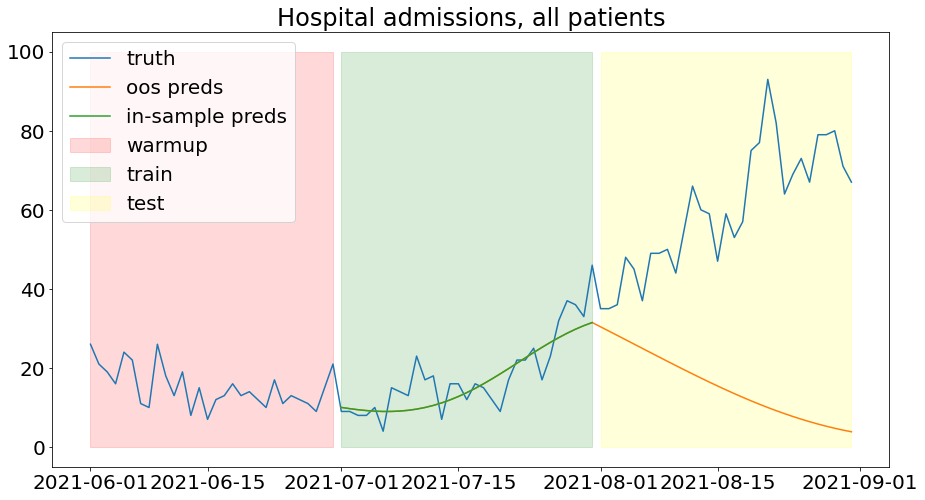

In [17]:
plt.figure(figsize=(15,8))    
plt.plot(df.loc[warmup_start:test_end].index.values,
        df.loc[warmup_start:test_end,'general_ward'].values, label = 'truth')
plt.plot(df.loc[train_start:test_end].index.values,
        test_preds, label = 'oos preds')
plt.plot(df.loc[train_start:train_end].index.values,
        preds, label = 'in-sample preds')
h1 = plt.fill_between(df.loc[warmup_start:warmup_end].index.values, 0, 100,alpha=0.15, color='red',label='warmup')
h2 = plt.fill_between(df.loc[train_start:train_end].index.values, 0, 100,alpha=0.15, color='green', label='train')
h3 = plt.fill_between(df.loc[test_start:test_end].index.values, 0, 100,alpha=0.15, color='yellow', label='test')
plt.legend()

plt.plot()

plt.title('Hospital admissions, all patients')


In [23]:
model.previously_extreme[0].stack()

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([14.205721 , 15.3890915, 16.551352 , 17.67047  , 18.718649 ,
       19.658566 , 20.43346  , 20.9436   , 20.466448 , 20.117855 ,
       19.903566 , 19.828203 , 19.894995 , 20.106493 , 20.464844 ,
       20.969835 , 21.620613 , 22.41491  , 23.348957 , 24.416483 ,
       25.610239 , 26.919239 , 28.332159 , 29.826889 , 31.383589 ,
       32.980003 , 34.58868  , 36.17975  , 37.71885  , 39.165592 ],
      dtype=float32)>

In [24]:
test_warmup_extreme[0]

array([ 8.92568308,  9.06718368,  9.24146712,  9.44915512,  9.690735  ,
        9.96624092, 10.27502781, 10.61263855, 10.98118777, 11.37959185,
       11.8056577 , 12.25885159, 12.73735869, 13.23777549, 13.75642505,
       14.29158122, 14.84119358, 15.4026385 , 15.97315282, 16.55093403,
       17.13097388, 17.71024727, 18.28819674, 18.86290265, 19.43235662,
       19.99623923, 20.55462787, 21.10388266, 21.6420796 , 22.16564178,
       22.68654268])

In [40]:
test_loss

<tf.Tensor: shape=(), dtype=float32, numpy=915.16846>

In [41]:
test_preds.shape

TensorShape([62])

In [42]:
testing_general_ward.shape

(62,)

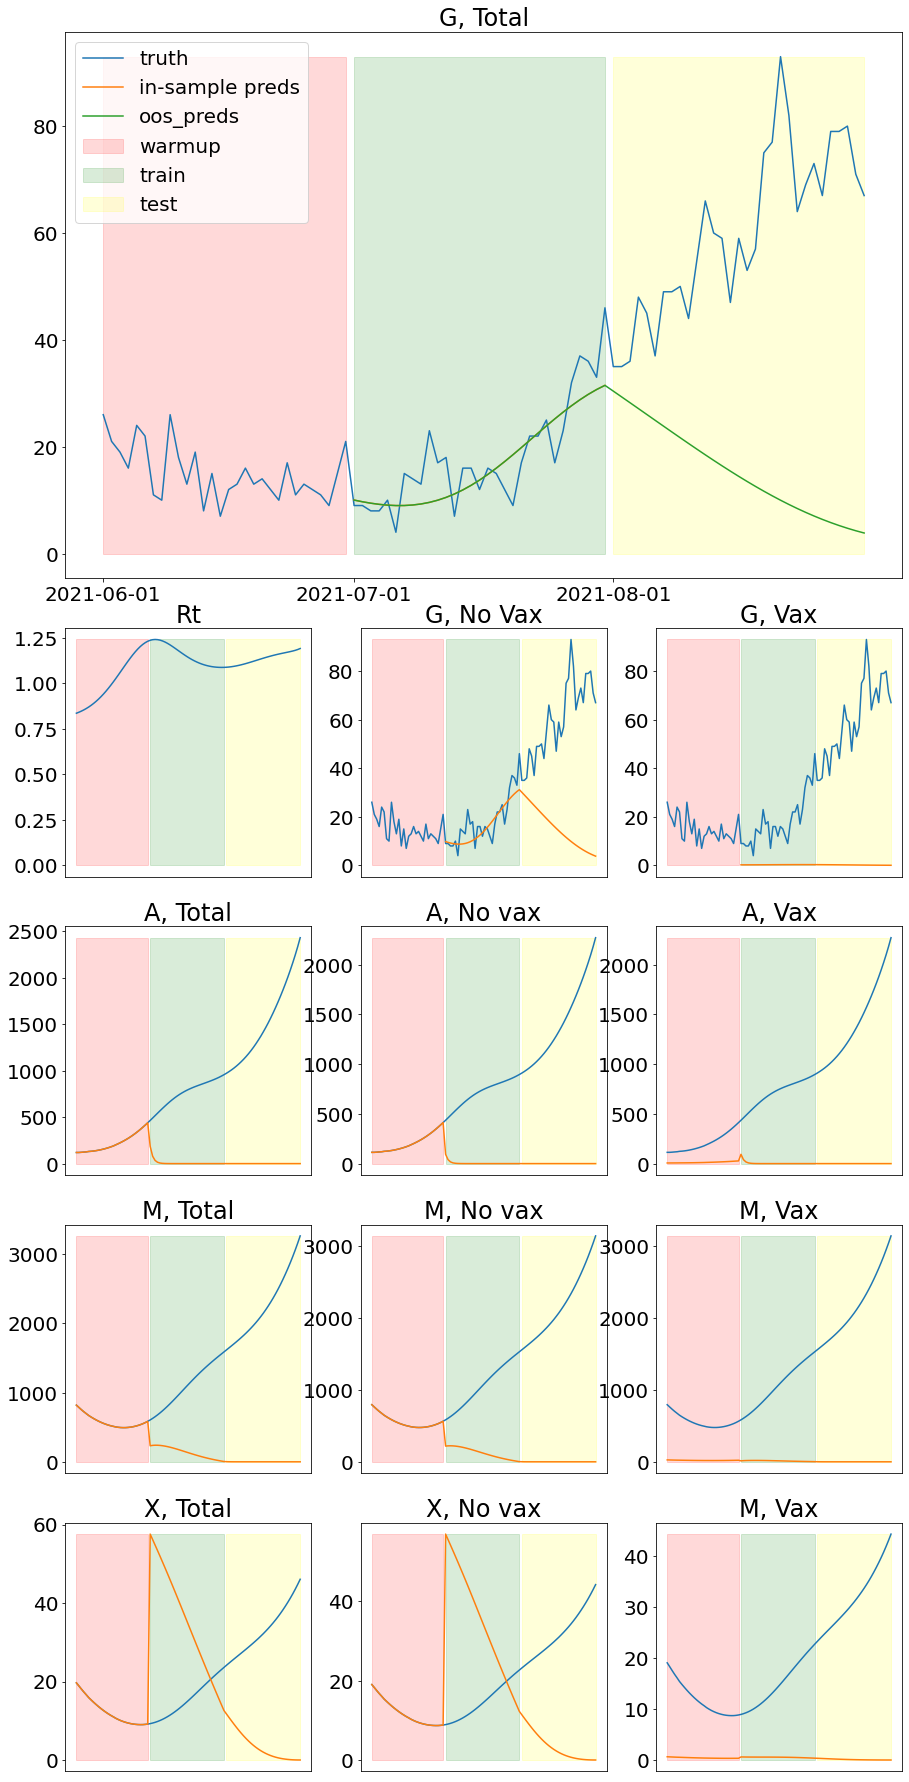

In [59]:
def plot_to_grid(ax, title,in_sample_preds=None,
                 oos_preds=None,
                 truth=None,
                 plot_legend=False, plot_ticks=False):
    
    provided_vals = []
    
    if truth is not None:
        ax.plot(truth[0],
            truth[1], label = 'truth')
        provided_vals += [truth[1]]
        
    if in_sample_preds is not None:
        ax.plot(in_sample_preds[0],
                in_sample_preds[1], label = 'in-sample preds')
        provided_vals += [in_sample_preds[1]]
    if oos_preds is not None:
        ax.plot(oos_preds[0],
                oos_preds[1], label = 'oos_preds')
        provided_vals += [oos_preds[1]]
    
    max_y = max([max(vals) for vals in provided_vals if vals is not None])

    h1 = ax.fill_between(df.loc[warmup_start:warmup_end].index.values, 0, max_y,alpha=0.15, color='red',label='warmup')
    h2 = ax.fill_between(df.loc[train_start:train_end].index.values, 0, max_y,alpha=0.15, color='green', label='train')
    h3 = ax.fill_between(df.loc[test_start:test_end].index.values, 0, max_y,alpha=0.15, color='yellow', label='test')
    
    if plot_legend:
        ax.legend()
    if plot_ticks:
        month_ticks = matplotlib.dates.MonthLocator(interval=1)
        ax.xaxis.set_major_locator(month_ticks)
        #cut off last tick
        ax.set_xticks(ax.get_xticks()[:-1])
    else:
        ax.set_xticks([])
    
    ax.title.set_text(title)

fig =plt.figure(figsize=(15,32))  

ax_hosp_tot = plt.subplot2grid((6, 3), (0, 0), colspan=3, rowspan=2)
ax_rt = plt.subplot2grid((6, 3), (2, 0))
ax_hosp_nonvax = plt.subplot2grid((6, 3), (2, 1))
ax_hosp_vax = plt.subplot2grid((6, 3), (2, 2))
ax_a_tot = plt.subplot2grid((6, 3), (3, 0))
ax_a_nonvax = plt.subplot2grid((6, 3), (3, 1))
ax_a_vax = plt.subplot2grid((6, 3), (3, 2))
ax_m_tot = plt.subplot2grid((6, 3), (4, 0))
ax_m_nonvax = plt.subplot2grid((6, 3), (4, 1))
ax_m_vax = plt.subplot2grid((6, 3), (4, 2))
ax_x_tot = plt.subplot2grid((6, 3), (5, 0))
ax_x_nonvax = plt.subplot2grid((6, 3), (5, 1))
ax_x_vax = plt.subplot2grid((6, 3), (5, 2))

all_days = df.loc[warmup_start:test_end].index.values
train_days = df.loc[train_start:train_end].index.values
test_days = df.loc[test_start:test_end].index.values
train_test_days = df.loc[train_start:test_end].index.values


plot_to_grid(ax_hosp_tot, 'G, Total',
             in_sample_preds=(train_days, preds),
             oos_preds=(train_test_days, test_preds),
             truth=(all_days, 
                    df.loc[warmup_start:test_end,'general_ward'].values),
             plot_legend=True, plot_ticks=True)

plot_to_grid(ax_rt, 'Rt',
             truth=(all_days, df.loc[warmup_start:test_end,'Rt'].values))


plot_to_grid(ax_hosp_nonvax, 'G, No Vax',
             truth=(all_days, df.loc[warmup_start:test_end,'general_ward'].values),
             oos_preds =(train_test_days, forecasted_fluxes[GENERAL_WARD][0].stack().numpy()))
plot_to_grid(ax_hosp_vax, 'G, Vax',
             truth=(all_days, df.loc[warmup_start:test_end,'general_ward'].values),
             oos_preds =(train_test_days, forecasted_fluxes[GENERAL_WARD][1].stack().numpy()))


asymp_vax_all_days = (df.loc[warmup_start:test_end, 'vax_pct'] * (1-vax_asymp_risk) * \
                           df.loc[warmup_start:test_end, 'asymp']).values
asymp_no_vax_all_days = df.loc[warmup_start:test_end, 'asymp'].values - asymp_vax_all_days

mild_vax_all_days = (df.loc[warmup_start:test_end, 'vax_pct'] * (1-vax_mild_risk) * \
                           df.loc[warmup_start:test_end, 'mild']).values
mild_no_vax_all_days = df.loc[warmup_start:test_end, 'mild'].values - mild_vax_all_days

extreme_vax_all_days = (df.loc[warmup_start:test_end, 'vax_pct'] * (1-vax_extreme_risk) * \
                           df.loc[warmup_start:test_end, 'extreme']).values
extreme_no_vax_all_days = df.loc[warmup_start:test_end, 'extreme'].values - extreme_vax_all_days

plot_to_grid(ax_a_tot, 'A, Total',
             truth=(all_days, df.loc[warmup_start:test_end,'asymp'].values),
             oos_preds =(all_days , forecasted_fluxes[ASYMP][0].stack()+forecasted_fluxes[ASYMP][1].stack()))
plot_to_grid(ax_a_nonvax, 'A, No vax',
             truth=(all_days, asymp_no_vax_all_days),
             oos_preds =(all_days , forecasted_fluxes[ASYMP][0].stack()))
plot_to_grid(ax_a_vax, 'A, Vax',
             truth=(all_days, asymp_no_vax_all_days),
             oos_preds =(all_days , forecasted_fluxes[ASYMP][1].stack()))

plot_to_grid(ax_m_tot, 'M, Total',
             truth=(all_days, df.loc[warmup_start:test_end,'mild'].values),
             oos_preds =(all_days , forecasted_fluxes[MILD][0].stack()+forecasted_fluxes[MILD][1].stack()))
plot_to_grid(ax_m_nonvax, 'M, No vax',
             truth=(all_days, mild_no_vax_all_days),
             oos_preds =(all_days , forecasted_fluxes[MILD][0].stack()))
plot_to_grid(ax_m_vax, 'M, Vax',
             truth=(all_days, mild_no_vax_all_days),
             oos_preds =(all_days , forecasted_fluxes[MILD][1].stack()))

plot_to_grid(ax_x_tot, 'X, Total',
             truth=(all_days, df.loc[warmup_start:test_end,'extreme'].values),
             oos_preds =(all_days , forecasted_fluxes[EXTREME][0].stack()+forecasted_fluxes[EXTREME][1].stack()))
plot_to_grid(ax_x_nonvax, 'X, No vax',
             truth=(all_days, extreme_no_vax_all_days),
             oos_preds =(all_days , forecasted_fluxes[EXTREME][0].stack()))
plot_to_grid(ax_x_vax, 'M, Vax',
             truth=(all_days, extreme_no_vax_all_days),
             oos_preds =(all_days , forecasted_fluxes[EXTREME][1].stack()))

   

In [65]:


ax_hosp_tot.plot(df.loc[warmup_start:test_end].index.values,
        df.loc[warmup_start:test_end,'general_ward'].values, label = 'truth')
ax_hosp_tot.plot(df.loc[train_start:test_end].index.values,
        test_preds, label = 'oos preds')
ax_hosp_tot.plot(df.loc[train_start:train_end].index.values,
        preds, label = 'in-sample preds')
h1 = ax_hosp_tot.fill_between(df.loc[warmup_start:warmup_end].index.values, 0, 100,alpha=0.15, color='red',label='warmup')
h2 = ax_hosp_tot.fill_between(df.loc[train_start:train_end].index.values, 0, 100,alpha=0.15, color='green', label='train')
h3 = ax_hosp_tot.fill_between(df.loc[test_start:test_end].index.values, 0, 100,alpha=0.15, color='yellow', label='test')
ax_hosp_tot.legend()
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax_hosp_tot.xaxis.set_major_locator(month_ticks)
#cut off last tick
ax_hosp_tot.set_xticks(ax_hosp_tot.get_xticks()[:-1])



ax_hosp_tot.title.set_text('Hospital Admissions, Total')

In [71]:
max([max(preds), max(test_preds)])

<tf.Tensor: shape=(), dtype=float32, numpy=31.492607>

In [77]:
df

,general_ward,infected,asymp,extreme,mild,Rt,vax_pct
date,,,,,,,
2019-12-25,NaN,0.000006,0.000006,6.555663e-11,5.714537e-08,0.992215,NaN
2019-12-26,NaN,0.000006,0.000006,5.584121e-10,3.892314e-07,1.055331,NaN
2019-12-27,NaN,0.000006,0.000005,2.045071e-09,1.009780e-06,1.110538,NaN
2019-12-28,NaN,0.000007,0.000005,4.996819e-09,1.784756e-06,1.158677,NaN
2019-12-29,NaN,0.000007,0.000004,9.617803e-09,2.581918e-06,1.201151,NaN
...,...,...,...,...,...,...,...
2021-08-31,67.0,5744.449475,2432.274877,4.605118e+01,3.266123e+03,1.190514,0.6597
2021-09-01,85.0,5959.757047,2537.002109,4.741058e+01,3.375344e+03,1.197465,0.6604
2021-09-02,72.0,NaN,NaN,NaN,NaN,NaN,0.6613


In [24]:
forecasted_fluxes[GENERAL_WARD][0].stack().numpy()

array([ 9.788135 ,  9.472811 ,  9.202766 ,  8.987371 ,  8.835369 ,
        8.755038 ,  8.757781 ,  8.849089 ,  9.037651 ,  9.331054 ,
        9.735262 , 10.253904 , 10.888852 , 11.639295 , 12.501808 ,
       13.470436 , 14.536306 , 15.690379 , 16.918118 , 18.204414 ,
       19.5322   , 20.88386  , 22.240837 , 23.584492 , 24.8964   ,
       26.158634 , 27.354204 , 28.467388 , 29.48412  , 30.391499 ,
       31.17882  , 30.104965 , 29.026093 , 27.943241 , 26.857561 ,
       25.770435 , 24.683483 , 23.59842  , 22.517286 , 21.442244 ,
       20.375546 , 19.319508 , 18.276518 , 17.248997 , 16.239372 ,
       15.2500725, 14.283489 , 13.341976 , 12.427702 , 11.542828 ,
       10.689396 ,  9.869347 ,  9.084465 ,  8.336378 ,  7.6265397,
        6.9562173,  6.326495 ,  5.7382665,  5.1922383,  4.6889186,
        4.2286625,  3.8116484], dtype=float32)

In [43]:
forecasted_fluxes[ASYMP][0].stack().numpy()+forecasted_fluxes[ASYMP][1].stack().numpy().shape

array([205.13111877, 205.2277298 , 206.94886017, 209.20359039,
       211.18775177, 215.23015594, 217.06484222, 219.83279419,
       223.47909546, 227.98396301, 233.129776  , 239.08052063,
       245.78334045, 253.25534058, 261.57350159, 270.56842041,
       281.9727478 , 293.26721191, 305.48054504, 318.24786377,
       332.11541748, 346.9569397 , 362.88146973, 379.97119141,
       398.14599609, 417.4262085 , 437.76132202, 459.18991089,
       481.34298706, 504.30108643, 185.3996582 , 131.77696609,
       108.95565605,  99.2224946 ,  95.06976056,  93.30011892,
        92.54802638,  92.22966971,  92.09561245,  92.03951322,
        92.01620244,  92.00659031,  92.00265874,  92.00106391,
        92.00042234,  92.00016636,  92.00006505,  92.00002526,
        92.00000975,  92.00000374,  92.00000143,  92.00000054,
        92.00000021,  92.00000008,  92.00000003,  92.00000001,
        92.        ,  92.        ,  92.        ,  92.        ,
        92.        ,  92.        ,  92.        ,  92.  